In [1]:
import time
import sys
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import seaborn as sns

from veloproj import *
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '3e-6', 
                               '--n-epochs', '20000', 
                               '--data-dir', '/data/users/cqiao/notebooks/data/organoids.hdf5',
                               '--model-name', 'scEU_model.cpt',
                               '--exp-name', 'CohAE_scEU',
                               '--device', 'cuda:0'
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("3", "1"), ("3", "2")]
k_cluster = "monocle_branch_id"
EXP_NAME = args.exp_name
exp_metrics = {}

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]
Filtered out 3746 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3831 × 2000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'rotated_umap1', 'rotated_umap2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'con

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_stochastical.png


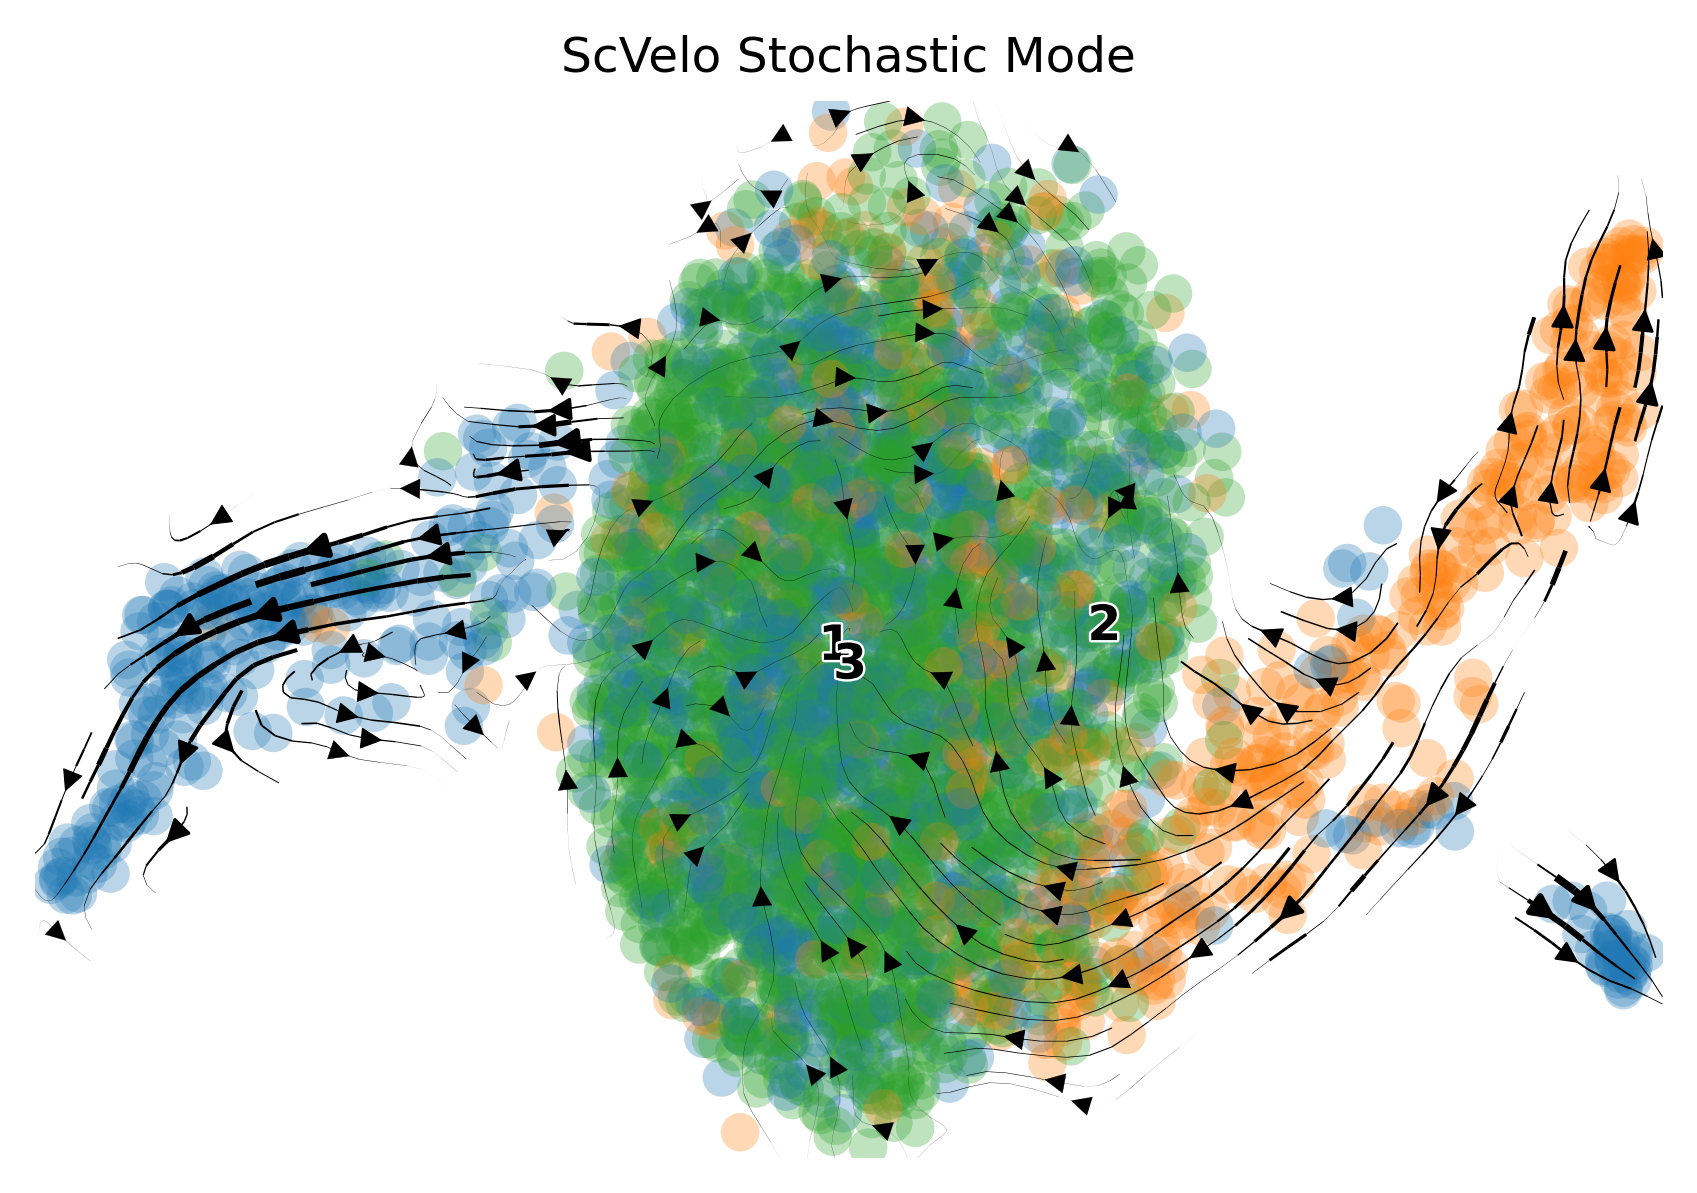

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.15114777, ('3', '2'): 0.08071256}
Total Mean: 0.11593016237020493
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.79889697, ('3', '2'): 0.8207498}
Total Mean: 0.8098233938217163
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.10821400009650162, ('3', '2'): 0.07437119337077965}
Total Mean: 0.09129259673364062
# In-cluster Coherence
{'1': 0.8049664, '2': 0.8545274, '3': 0.83366334}
Total Mean: 0.8310523629188538
# In-cluster Confidence
{'1': 0.7199635048156345, '2': 0.7906047247751308, '3': 0.7805492314829755}
Total Mean: 0.7637058203579136


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['monocle_branch_id'],
                                 dpi=350,
                                title='ScVelo Stochastic Mode', save="scEU_stochastical.png")
exp_metrics['stc_mode'] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

recovering dynamics
    finished (0:32:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:10) --> added 
    'dyn_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:03) --> added 
    'dyn_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dyn_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_dynamical.png


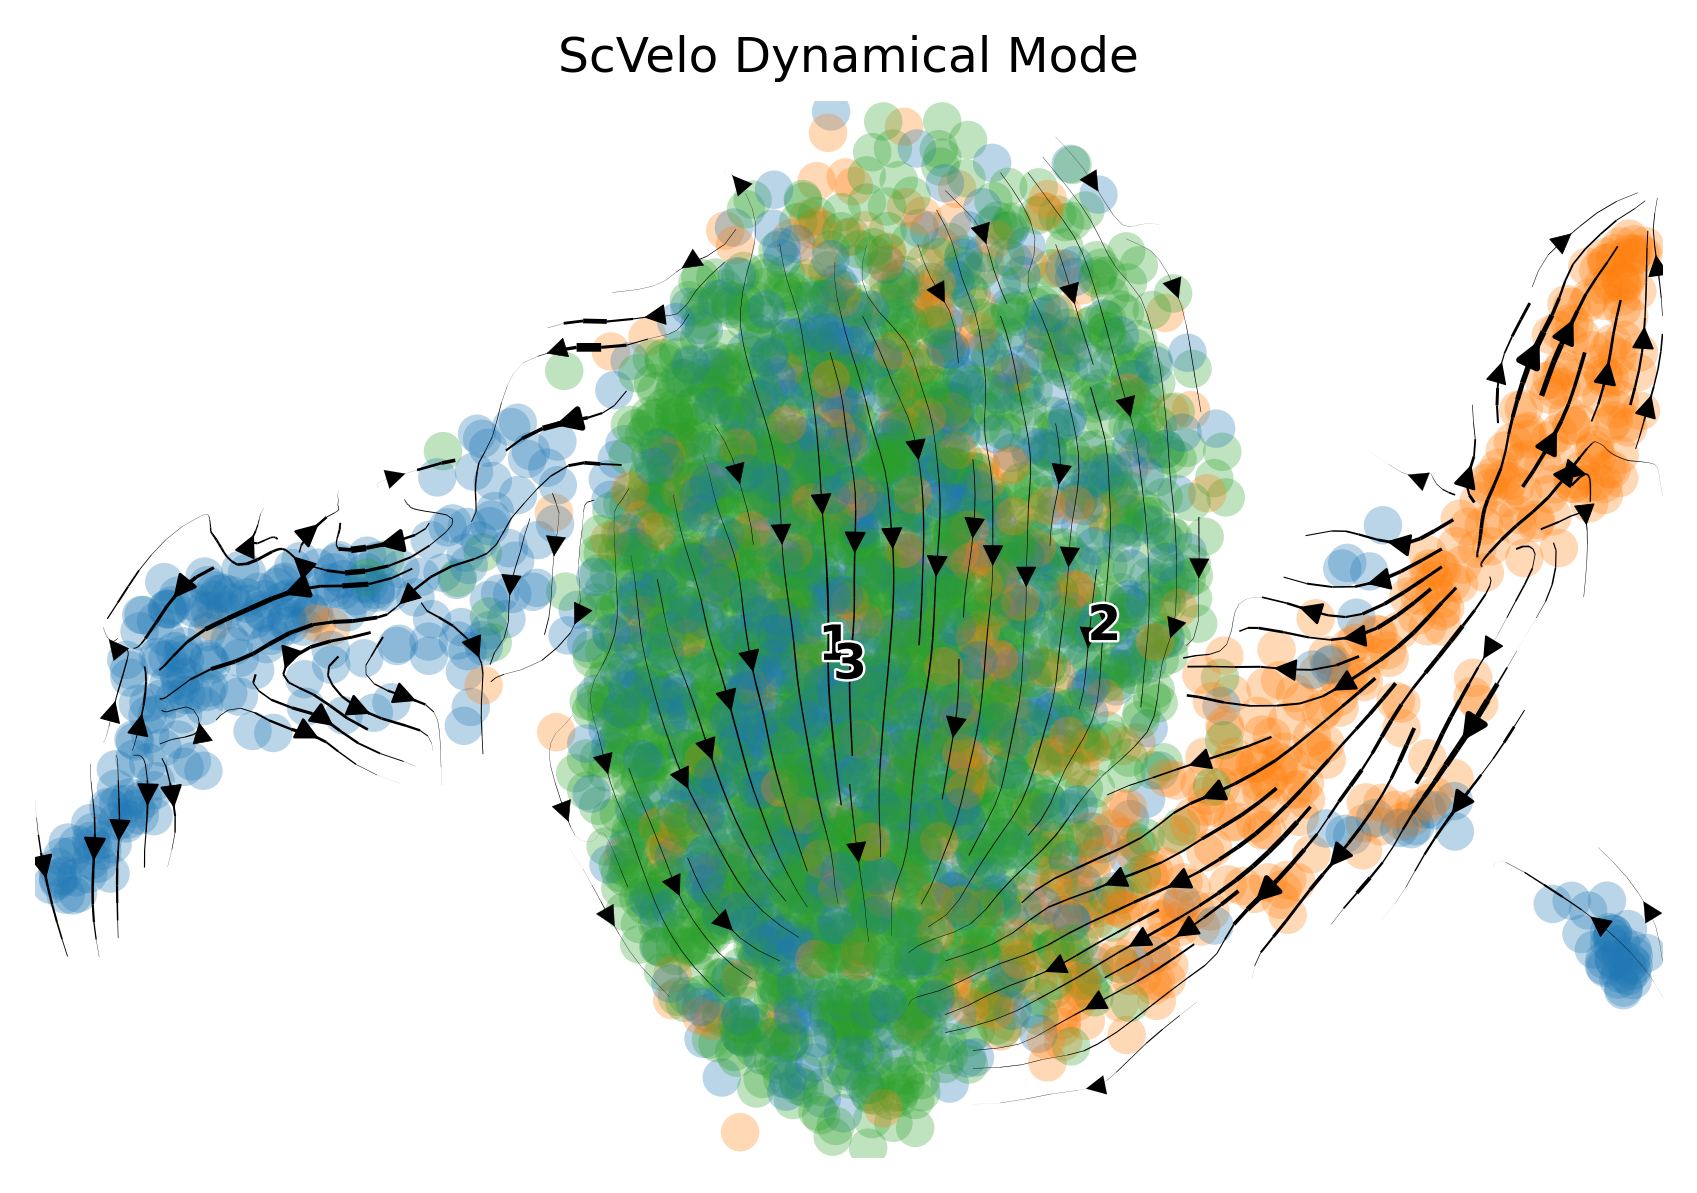

--> added 'dyn_velocity_length' (adata.obs)
--> added 'dyn_velocity_confidence' (adata.obs)
--> added 'dyn_velocity_confidence_transition' (adata.obs)


In [8]:
scv.tl.recover_dynamics(adata, max_iter=100, use_raw=False, var_names="all")
scv.tl.velocity(adata, vkey='dyn_velocity', mode='dynamical', use_raw=False)
scv.tl.velocity_graph(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="dyn_velocity", color=[k_cluster], basis='X_umap', dpi=350,
                                title='ScVelo Dynamical Mode', save="scEU_dynamical.png")
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
# exp_metrics['scv Dynamical'] = evaluate(adata, cluster_edges, k_cluster, "dyn_velocity", 'tsne_cell_embeddings')

In [9]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

In [11]:
n_cells, n_genes = adata.X.shape
z_dim = args.z_dim
g_rep_dim = args.g_rep_dim
h_dim = args.h_dim
k_dim = args.k_dim
    
G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())

model = get_CohAE(
                 adata, 
                 z_dim, 
                 n_genes, 
                 n_cells, 
                 h_dim, 
                 k_dim, 
                 G_embeddings=G_embeddings, 
                 g_rep_dim=g_rep_dim,
                 device=device
                )
model.load_state_dict(torch.load(args.model_name))
model = model.to(device)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


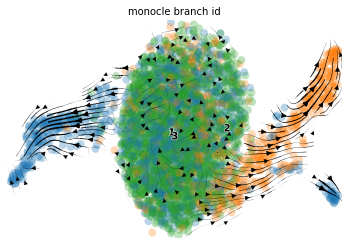

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.13377286, ('3', '2'): 0.12021996}
Total Mean: 0.12699641287326813
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.97376025, ('3', '2'): 0.9774715}
Total Mean: 0.9756158590316772
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.05684226766199223, ('3', '2'): 0.1330146385672316}
Total Mean: 0.09492845311461193
# In-cluster Coherence
{'1': 0.9684339, '2': 0.9734222, '3': 0.97821474}
Total Mean: 0.9733569622039795
# In-cluster Confidence
{'1': 0.9642518422264137, '2': 0.9683201563883372, '3': 0.9769428323750472}
Total Mean: 0.9698382769965993


In [13]:
def exp(adata, exp_metrics):
    new_v_key = "new_velocity"
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False, new_v_key=new_v_key)
    scv.pp.neighbors(adata, n_neighbors=30)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity_graph(adata, vkey=new_v_key)
    scv.tl.velocity_confidence(adata, vkey=new_v_key)
    scv.pl.velocity_embedding_stream(adata, vkey=new_v_key, basis='X_umap', color='monocle_branch_id')
    evaluate(adata, cluster_edges, k_cluster, new_v_key)
    return x, u, s, v
    
x, u, s, v = exp(adata, exp_metrics)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


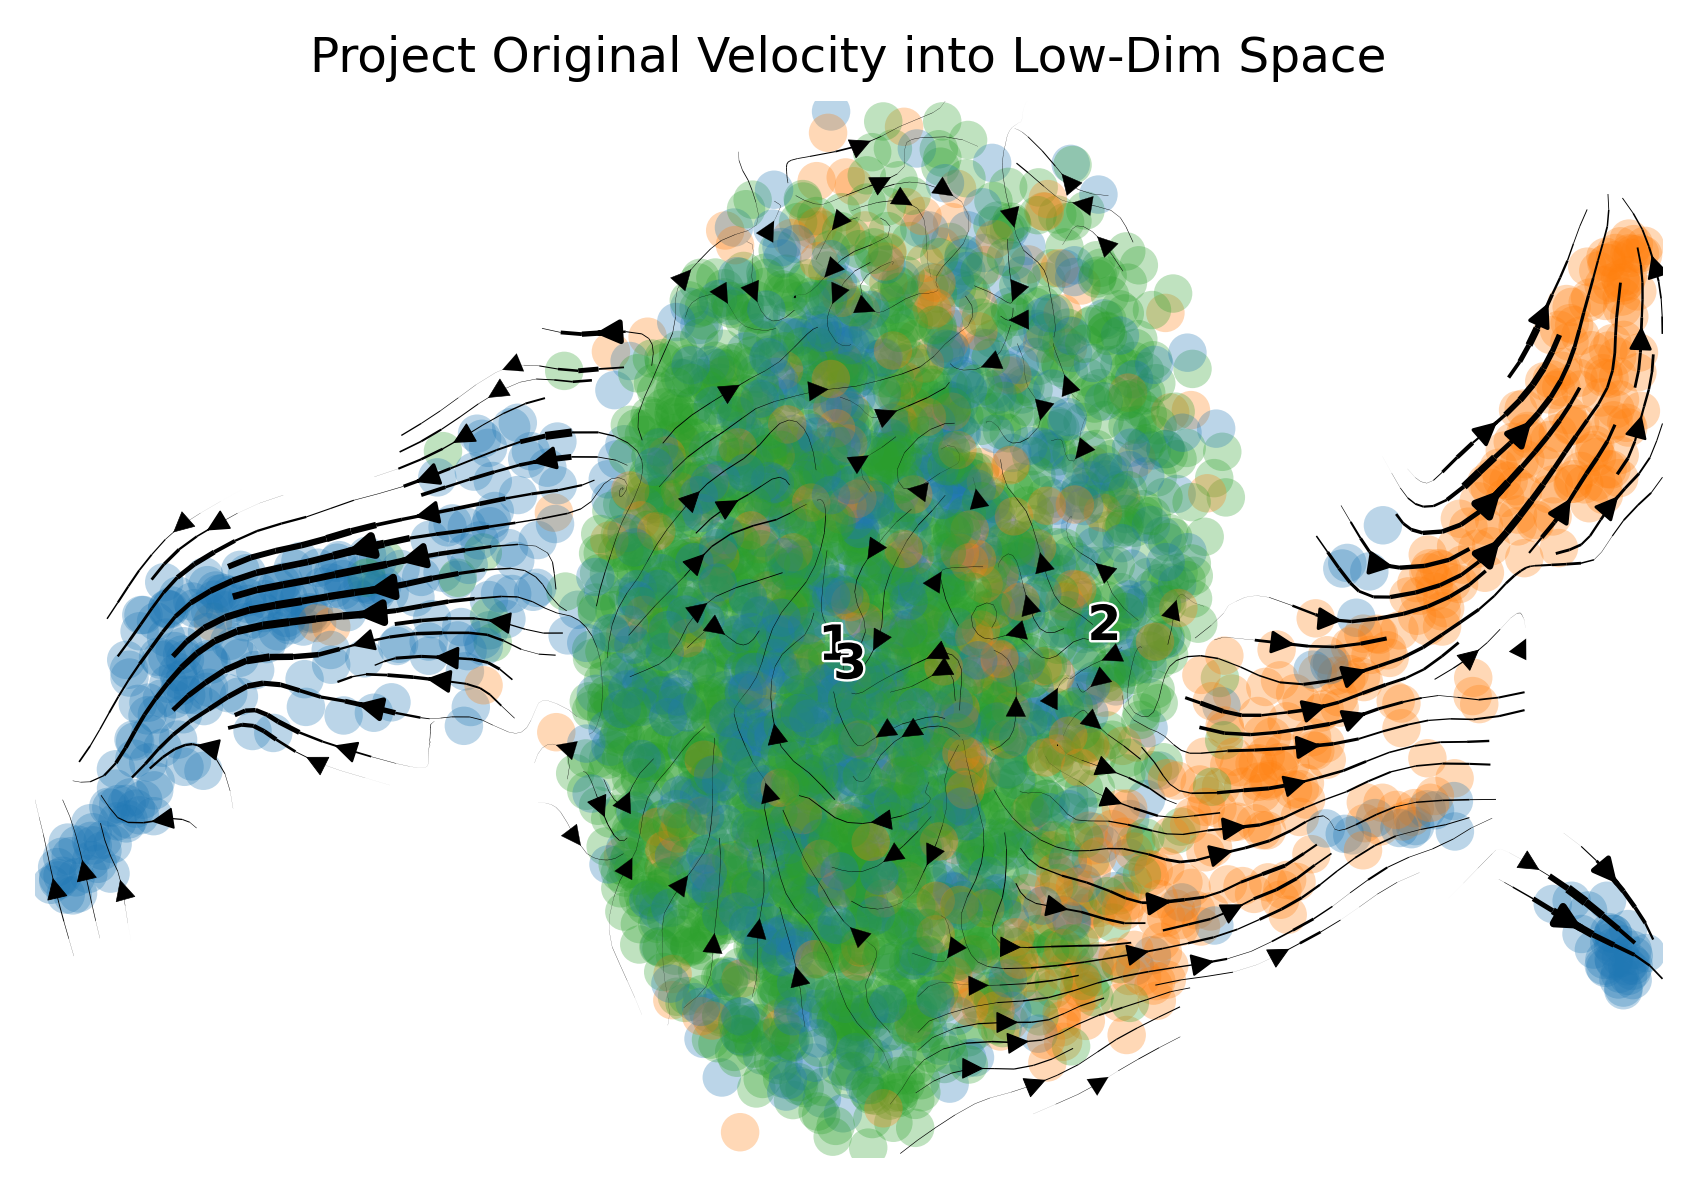

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)


In [14]:
def exp(adata, exp_metrics):
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s

    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['monocle_branch_id'],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    
exp(adata, exp_metrics)

In [16]:
import seaborn as sns
def draw():
    
    ordered_sel_branch2 = (adata.obs.monocle_branch_id == "2").values
    ordered_sel_branch2 = np.argwhere(ordered_sel_branch2 == True).flatten()
    ordered_sel_branch2, _ = zip(*sorted(zip(ordered_sel_branch2, adata.obs.monocle_pseudotime[ordered_sel_branch2]), key=lambda xy: xy[1]))
    ordered_sel_branch2 = np.array(ordered_sel_branch2)

    X_std = x[ordered_sel_branch2].T
    X_std = (X_std - np.min(X_std, axis=0, keepdims=True)) / (np.max(X_std, axis=0, keepdims=True) -  np.min(X_std, axis=0, keepdims=True))
    df2 = pd.DataFrame(X_std, columns=ordered_sel_branch2)
#     grid = sns.clustermap(df2.iloc[np.concatenate([enriched_dim_branch2[:15], enriched_dim_branch1[:15][::-1]])], col_cluster=False, row_cluster=False, cmap="YlGnBu")
#     plt.title("Mono Branch 2 Low-Dim X Cells ordered by Pseudotime")
    return df2
df2z = draw()

In [17]:
def draw():
    ordered_sel_branch1 = (adata.obs.monocle_branch_id == "1").values
    ordered_sel_branch1 = np.argwhere(ordered_sel_branch1 == True).flatten()
    ordered_sel_branch1, _ = zip(*sorted(zip(ordered_sel_branch1, adata.obs.monocle_pseudotime[ordered_sel_branch1]), key=lambda xy: xy[1]))
    ordered_sel_branch1 = np.array(ordered_sel_branch1)
    X_std = x[ordered_sel_branch1].T
    X_std = (X_std - np.min(X_std, axis=0, keepdims=True)) / (np.max(X_std, axis=0, keepdims=True) -  np.min(X_std, axis=0, keepdims=True))
    df1 = pd.DataFrame(X_std, columns=ordered_sel_branch1)
    
#     plt.yticks(ticks=grid.data2d.index, labels=grid.data2d.index)
#     plt.title("Mono Branch 2 Low-Dim X by Cells ordered by Pseudotime")
    return df1
df1z = draw()

(54, 85, 90, 4, 2, 25, 62, 22, 36, 66, 46, 59, 75, 9, 64, 52, 20, 70, 74, 87, 71, 86, 28, 99, 81, 7, 91, 60, 26, 73, 39, 43, 44, 33, 83, 51, 42, 92, 40, 67, 18, 30, 38, 21, 50, 11, 47)
(53, 17, 32, 61, 49, 56, 48, 19, 8, 65, 1, 98, 14, 80, 3, 58, 34, 45, 84, 27, 82, 95, 31, 69, 16, 94, 79, 15, 41, 55, 13, 0, 68, 24, 76, 63, 7, 6, 12, 97, 5, 93, 87, 89, 96, 88, 77, 86, 33, 72, 74, 22, 57, 59, 73, 78, 51, 39, 10, 30, 29, 70, 92, 9, 23, 2, 67, 42, 46, 43, 18, 91, 66, 60, 62, 75, 99, 83, 11, 28, 37, 44, 52, 26, 20, 40, 47, 36, 25, 71, 81, 90, 64, 21, 4, 35, 50, 38, 85, 54)


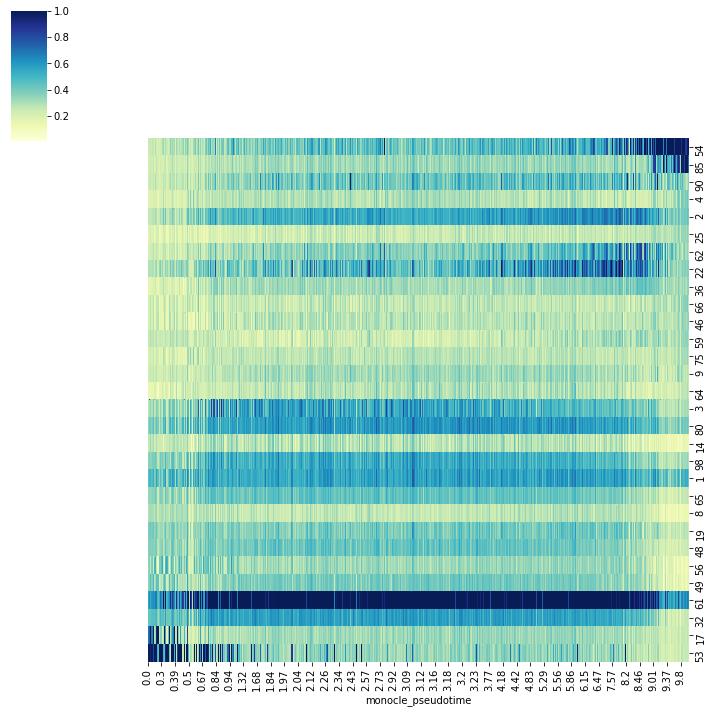

In [19]:
dfmz = pd.concat([df1z, df2z], axis=1)
dfmz.columns = pd.Series(np.concatenate([np.round(adata.obs.monocle_pseudotime[df1z.columns],2),
                                         np.round(adata.obs.monocle_pseudotime[df2z.columns],2)]), 
                         name="monocle_pseudotime")
def cmp_bin_means(row):
    length = len(row)
    left_mean = np.mean(row[:20])
    right_mean = np.mean(row[-20:])
    l_mid_mean = np.mean(row[1208-20:1208])
    r_mid_mean = np.mean(row[1208:1208+20])                            
    return left_mean, l_mid_mean, r_mid_mean, right_mean
bin_means = list(map(cmp_bin_means, dfmz.values))
enriched_dim_branch2 = [(idx, r + r-lm + rm - l) for idx, (l,lm,rm, r) in enumerate(bin_means) if r - l > 0]

enriched_dim_branch2 , _ = zip(*sorted(enriched_dim_branch2, key=lambda x: x[1], reverse=True))
print(enriched_dim_branch2)
enriched_dim_branch1 = [(idx, l + l-rm + lm - r) for idx, (l,lm,rm, r) in enumerate(bin_means) if l -  r]

enriched_dim_branch1 , _ = zip(*sorted(enriched_dim_branch1, key=lambda x: x[1], reverse=True))
print(enriched_dim_branch1)
ax = sns.clustermap(dfmz.iloc[np.concatenate([enriched_dim_branch2[:15], enriched_dim_branch1[:15][::-1]])], cmap="YlGnBu", row_cluster=False, col_cluster=False, yticklabels=True)
ax.savefig(f"./figures/{args.exp_name}_low_dim_x.png", dpi=350)

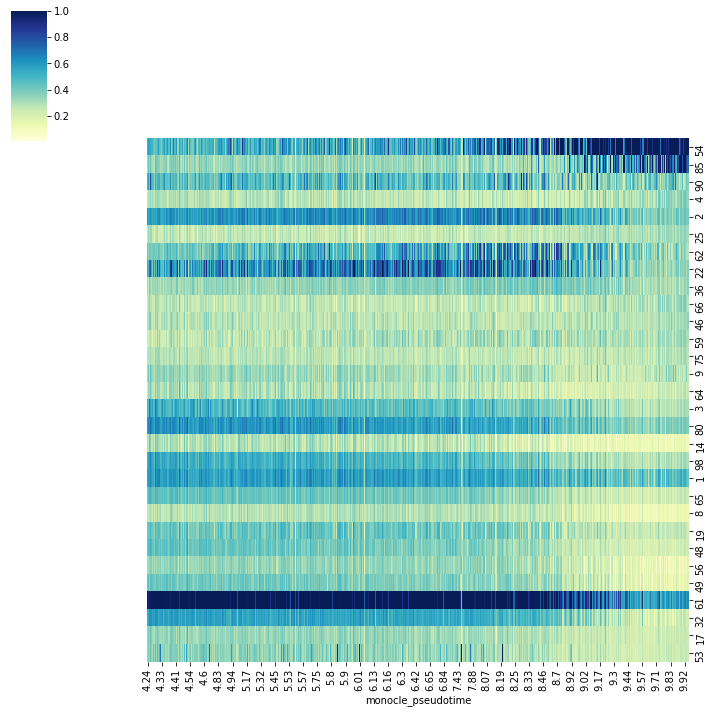

In [20]:
clms = df2z.columns
df2z.columns = pd.Series(np.round(adata.obs.monocle_pseudotime[df2z.columns],2), name="monocle_pseudotime")
ax = sns.clustermap(df2z.iloc[np.concatenate([enriched_dim_branch2[:15], enriched_dim_branch1[:15][::-1]])], col_cluster=False, row_cluster=False, cmap="YlGnBu")
df2z.columns = clms

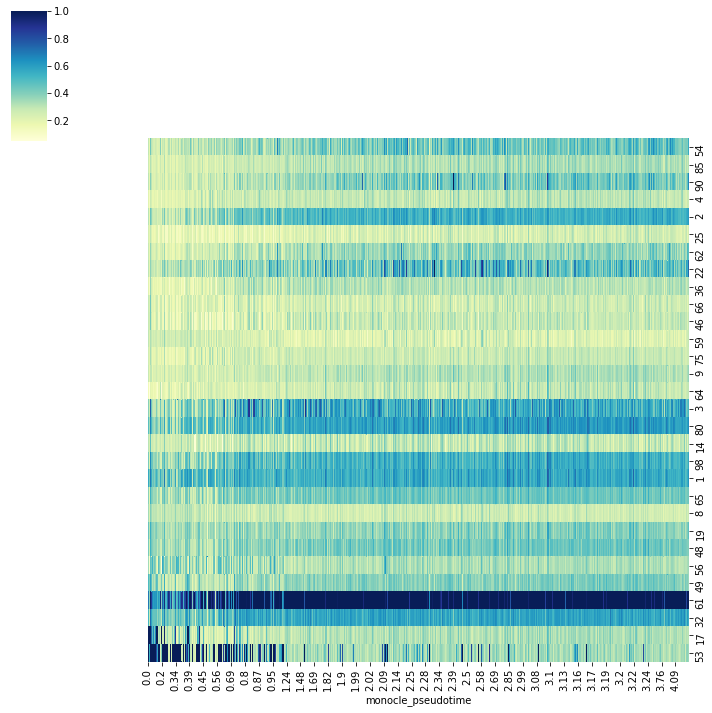

In [21]:
clms = df1z.columns
df1z.columns = pd.Series(np.round(adata.obs.monocle_pseudotime[df1z.columns],2), name="monocle_pseudotime")
ax = sns.clustermap(df1z.iloc[np.concatenate([enriched_dim_branch2[:15], enriched_dim_branch1[:15][::-1]])], cmap="YlGnBu", row_cluster=False, col_cluster=False)
df1z.columns = clms

In [23]:
sel_3 = (adata.obs.monocle_branch_id == '3').values
sel_2 = (adata.obs.monocle_branch_id == '2').values
sel_1 = (adata.obs.monocle_branch_id == '1').values
start_sel = []

for ith, nb in enumerate(adata.uns['neighbors']['indices'][sel_2]):
    for idx in nb:
        if sel_3[idx] == True:
            edge_node = np.argwhere(sel_2 == True).flatten()[ith]
            start_sel.append(edge_node)
            break

In [24]:
def exp():
    x = model.encoder(tensor_x).detach()
    s = model.encoder(tensor_s).detach()
    u = model.encoder(tensor_u).detach()
    v = model.encoder(tensor_v + tensor_s).detach() - s
    attens = model.decoder(x, True)[1].detach().cpu().numpy()
    return attens
    
attens = exp()

In [28]:
interested_genes = ["Apoa1", "Ephx2", "Cyp3a25", "Gstm3", "Muc3", 
                    'Dclk1',
                    'Defa24', 'Defa17', 'Rnase4', 'Lyz1']
int_gene_indices = [np.argwhere((adata.var.gene == gene).values).item() for gene in interested_genes]
        
target_attens = attens[:, int_gene_indices]
hard_assignments = {}
for x, y in zip(np.argmax(target_attens, axis=0), interested_genes):
    hard_assignments[y] = x
#     print(f'\tGene {y}, \t attention hard assigned to low-dim {x}')
    
from collections import Counter
cluster_stats = Counter(hard_assignments.values())
cluster_stats

Counter({85: 1, 9: 4, 97: 1, 17: 4})

In [31]:
hard_assignments

{'Apoa1': 85,
 'Ephx2': 9,
 'Cyp3a25': 9,
 'Gstm3': 9,
 'Muc3': 9,
 'Dclk1': 97,
 'Defa24': 17,
 'Defa17': 17,
 'Rnase4': 17,
 'Lyz1': 17}

In [52]:
for x, y in zip(np.argmax(target_attens, axis=0), interested_genes):
    if y == "Apoa1":
        print('Genes most indicatve of Branch 2')
    if y == "Defa24":
        print('Gene most indicatve of Branch 1')
    if y == "Lgr5":
        print('other')
    if y == "Dclk1":
        print('Gene most indicatve of Tuft cells')
    print(f'\tGene {y}, \t attention hard assigned to low-dim {x}')

Genes most indicatve of Branch 2
	Gene Apoa1, 	 attention hard assigned to low-dim 85
	Gene Ephx2, 	 attention hard assigned to low-dim 9
	Gene Cyp3a25, 	 attention hard assigned to low-dim 9
	Gene Gstm3, 	 attention hard assigned to low-dim 9
	Gene Muc3, 	 attention hard assigned to low-dim 9
other
	Gene Lgr5, 	 attention hard assigned to low-dim 76
	Gene Sox9, 	 attention hard assigned to low-dim 76
	Gene Mki67, 	 attention hard assigned to low-dim 88
	Gene Sox4, 	 attention hard assigned to low-dim 77
Gene most indicatve of Tuft cells
	Gene Dclk1, 	 attention hard assigned to low-dim 97
Gene most indicatve of Branch 1
	Gene Defa24, 	 attention hard assigned to low-dim 17
	Gene Defa17, 	 attention hard assigned to low-dim 17
	Gene Rnase4, 	 attention hard assigned to low-dim 17
	Gene Lyz1, 	 attention hard assigned to low-dim 17


(1208,)


Text(0.5, 1.0, 'Squre Root of Observed Expression of Branch 1 Cells')

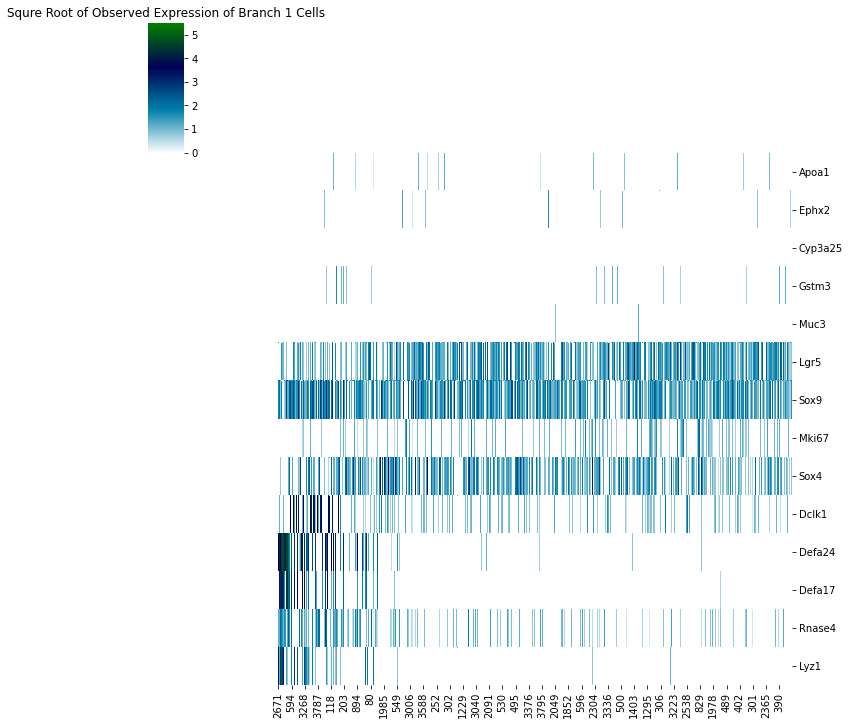

In [55]:
ordered_sel_branch1 = (adata.obs.monocle_branch_id == "1").values
ordered_sel_branch1 = np.argwhere(ordered_sel_branch1 == True).flatten()
print(np.shape(ordered_sel_branch1))
ordered_sel_branch1, _ = zip(*sorted(zip(ordered_sel_branch1, adata.obs.monocle_pseudotime[ordered_sel_branch1]), key=lambda xy: xy[1]))
ordered_sel_branch1 = np.array(ordered_sel_branch1)
data = np.log(tensor_x.cpu().numpy()[ordered_sel_branch1].T[int_gene_indices] + 1)
df1 = pd.DataFrame(data, columns=ordered_sel_branch1, index=interested_genes)
ax = sns.clustermap(df1, cmap="ocean_r", row_cluster=False, col_cluster=False)
plt.title("Squre Root of Observed Expression of Branch 1 Cells")

(613,)


Text(0.5, 1.0, 'Squre Root of Observed Expression of Branch 2 Cells')

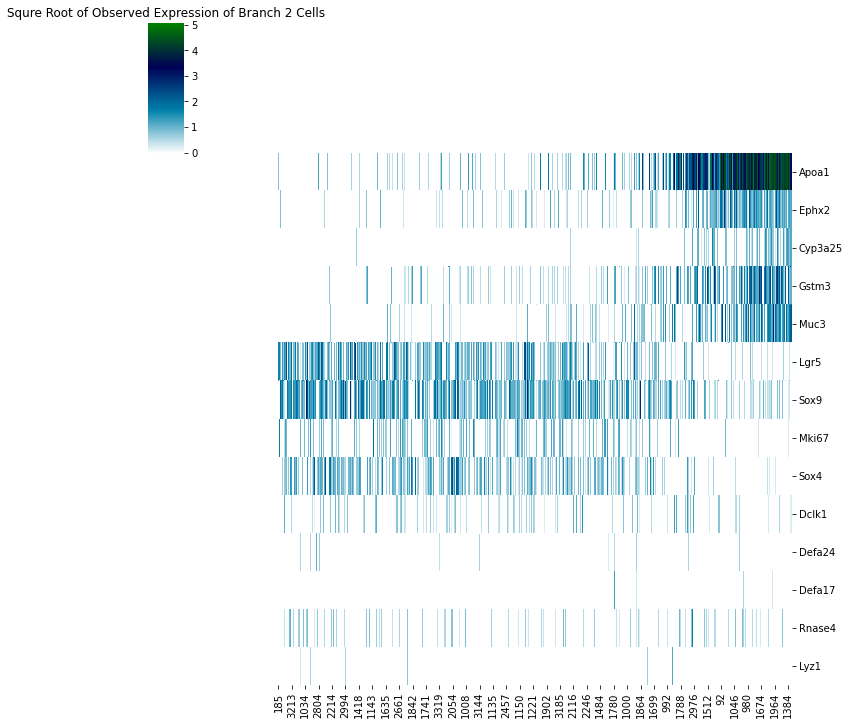

In [56]:
ordered_sel_branch2 = (adata.obs.monocle_branch_id == "2").values
ordered_sel_branch2 = np.argwhere(ordered_sel_branch2 == True).flatten()
print(np.shape(ordered_sel_branch2))
ordered_sel_branch2, _ = zip(*sorted(zip(ordered_sel_branch2, adata.obs.monocle_pseudotime[ordered_sel_branch2]), key=lambda xy: xy[1]))
ordered_sel_branch2 = np.array(ordered_sel_branch2)

data = np.log(tensor_x.cpu().numpy()[ordered_sel_branch2].T[int_gene_indices] + 1)
df2 = pd.DataFrame(data, columns=ordered_sel_branch2, index=interested_genes)
ax = sns.clustermap(df2, cmap="ocean_r", row_cluster=False, col_cluster=False)
plt.title("Squre Root of Observed Expression of Branch 2 Cells")

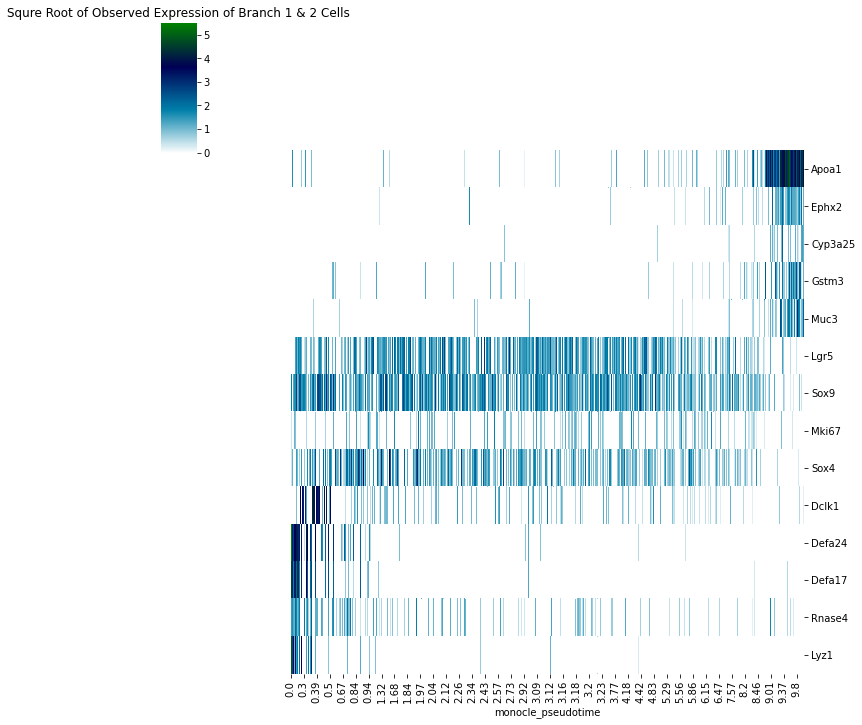

In [58]:
df_m = pd.concat([df1, df2], axis=1)
df_m.columns = adata.obs.monocle_pseudotime[np.concatenate([df1.columns, df2.columns])].round(2)
ax = sns.clustermap(df_m, cmap="ocean_r", row_cluster=False, col_cluster=False)
plt.title("Squre Root of Observed Expression of Branch 1 & 2 Cells")
ax.savefig(f"./figures/{args.exp_name}_fig3f_rep.png")

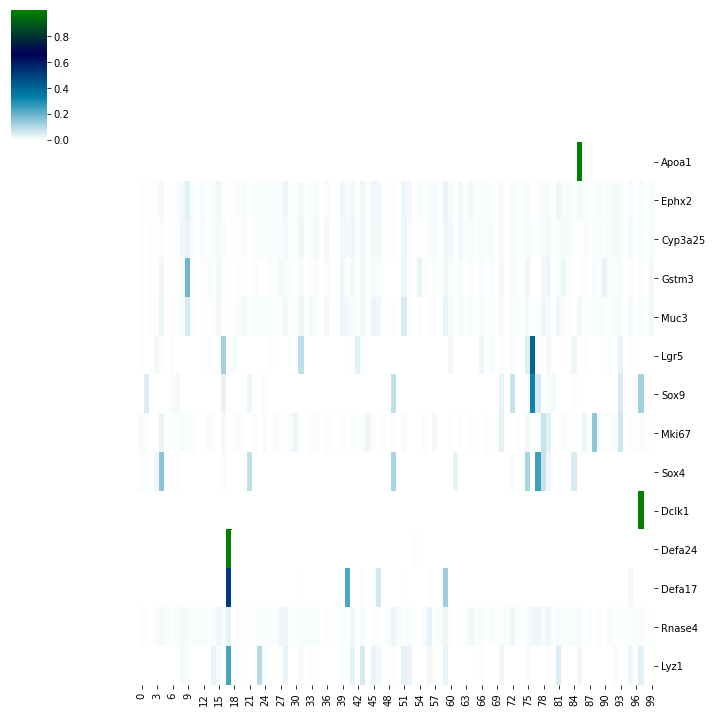

In [59]:
df_gene_atten = pd.DataFrame(np.power(attens[:, int_gene_indices].T, 1), index=interested_genes)
ax = sns.clustermap(df_gene_atten, col_cluster=False, row_cluster=False, cmap="ocean_r")
ax.savefig(f"./figures/{args.exp_name}_atten_hard_cluster.png", dpi=350)